In [1]:
from IPython.display import display, HTML, Image
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
import argparse
import csv
import getpass
import json
import time
import types, copy, pprint
import logging 
import re
import shutil
import yaml
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
        
import wandb
import glob
from matplotlib import pyplot as plt
from typing import Dict, List, Tuple
from scipy.sparse import csr_matrix
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torchinfo import summary

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
print(torch.__version__)

pd.options.display.width = 132
pp = pprint.PrettyPrinter(indent=4)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)

os.environ["WANDB_NOTEBOOK_NAME"] = "Adashare_Train.ipynb"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
 
from KevinsRoutines.utils.utils_wandb  import  init_wandb, wandb_log_metrics,wandb_watch
from KevinsRoutines.utils.utils_general  import  list_namespace 

import snnl.utils as utils 

from snnl.utils import parse_args, load_configuration, set_global_seed, get_device, set_device
from snnl.utils import display_model_summary, define_autoencoder_model
# from snnl.utils import load_model, save_model, import_results, export_results
# from snnl.utils import plot_model_parms, plot_train_history, plot_classification_metrics, plot_regression_metrics
# from snnl.utils import display_epoch_metrics, display_cellpainting_batch
# from snnl.utils import CellpaintingDataset, InfiniteDataLoader, custom_collate_fn
# from snnl.utils import save_checkpoint_v2, load_checkpoint_v2, save_checkpoint_v3

from snnl.models import Model
from snnl.models import DNN 
from snnl.models import Autoencoder
from snnl.losses import SNNLoss

insert ./src
insert ../..
2.2.1+cu118


In [3]:
 
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__) 
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
logger.info(f" Pytorch version  : {torch.__version__}")
# logger.info(f" Search path      : {sys.path}")

2024-07-09 23:16:23,881 - __main__ - INFO: -  Excution started : 2024_07_09_23:16:23 
2024-07-09 23:16:23,882 - __main__ - INFO: -  Pytorch version  : 2.2.1+cu118


In [4]:
import sklearn.metrics as skm 
import scipy.stats as sps 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform, euclidean
import matplotlib.pyplot as plt
import seaborn as sb

# from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_fscore_support
# from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Setup

In [5]:
LATENT_DIM = 150
HIDDEN_1   = '512'
# HIDDEN_2   = '_256'
HIDDEN_2   = ''
DATE       = '20240616'
LOAD_EPOCH = '025'
EPOCHS     = 10
COMPOUNDS_PER_BATCH = 200

#### main(args)

In [6]:
# if __name__ == "__main__":
cli_args = f" --seed              1234 " \
           f" --runmode             baseline" \
           f" --configuration       ./hyperparameters/ae_cp_250_512_cpb.yaml" \
           f" --gpu_id              2 "\
           f" --cpb                 200" \
           f" --epochs              20"
           # f" --runmode           snnl" \
           # f" --configuration     hyperparameters/dnn_mnist.json"
cli_args = parse_args(cli_args.split())
cli_args

args = load_configuration(cli_args)
args.ckpt


Namespace(configuration='./hyperparameters/ae_cp_250_512_cpb.yaml', ckpt=None, cpb=200, exp_title=None, epochs=20, gpu_id=2, learning_rate=None, exp_id=None, runmode='baseline', random_seed=1234, use_prim_optimizer=False, use_temp_optimizer=False, use_annealing=False, use_single_loss=False, temperature=None, temperatureLR=None, wandb=False)

2024-07-09 23:16:24,091 - snnl.utils.utils - INFO: -  command line param configuration             : [./hyperparameters/ae_cp_250_512_cpb.yaml]
2024-07-09 23:16:24,092 - snnl.utils.utils - INFO: -  command line param ckpt                      : [None]
2024-07-09 23:16:24,093 - snnl.utils.utils - INFO: -  command line param cpb                       : [200]
2024-07-09 23:16:24,093 - snnl.utils.utils - INFO: -  command line param exp_title                 : [None]
2024-07-09 23:16:24,094 - snnl.utils.utils - INFO: -  command line param epochs                    : [20]
2024-07-09 23:16:24,095 - snnl.utils.utils - INFO: -  command line param gpu_id                    : [2]
2024-07-09 23:16:24,096 - snnl.utils.utils - INFO: -  command line param learning_rate             : [None]
2024-07-09 23:16:24,096 - snnl.utils.utils - INFO: -  command line param exp_id                    : [None]
2024-07-09 23:16:24,097 - snnl.utils.utils - INFO: -  command line param runmode                   : [base

In [7]:
args

namespace(project_name='CellPainting_Profiles',
          exp_id=None,
          exp_name_pfx=None,
          exp_name=None,
          exp_title='scpb200-250Ltnt_512',
          exp_description='AE baseline - snglOpt, 250 dim latent, 512 Midlayer, 200 cpb',
          exp_folder=None,
          folder_sfx=None,
          random_seed=1234,
          units=[['linear', 1471, 1024],
                 ['relu', 0, 0],
                 ['linear', 1024, 512],
                 ['relu', 0, 0],
                 ['linear', 512, 250],
                 ['linear', 250, 512],
                 ['relu', 0, 0],
                 ['linear', 512, 1024],
                 ['relu', 0, 0],
                 ['linear', 1024, 1471]],
          input_shape=1471,
          code_units=250,
          embedding_layer=4,
          show_every=1,
          save_every=25,
          learning_rate=0.001,
          loss_factor=1.0,
          adam_weight_decay=0,
          snnl_factor=0.0,
          temperature=0.0,
          te

In [8]:
set_global_seed(args.random_seed)
if args.ckpt is not None:
    if os.path.exists(os.path.join('ckpts', args.ckpt)):
        logger.info(f" Checkpoint {args.ckpt} found")
        logger.info(f" Resuming training using checkpoint: {args.ckpt}")
    else:
        logger.error(f" *** Checkpoint {args.ckpt} not found *** \n")
        raise ValueError(f"\n *** Checkpoint DOESNT EXIST *** \n")

In [9]:
if args.gpu_id is not None:
    _ = get_device()
    # print(f"Current device is : {current_device}")    
    current_device = set_device(args.gpu_id)
    current_device = get_device()

2024-07-09 23:16:25,125 - snnl.utils.utils - INFO: -  Current CUDA Device is:  cuda:0 - Quadro GV100
2024-07-09 23:16:25,126 - snnl.utils.utils - INFO: -  Switched to: NVIDIA TITAN Xp - 2
2024-07-09 23:16:25,127 - snnl.utils.utils - INFO: -  Current CUDA Device is:  cuda:2 - NVIDIA TITAN Xp


### Load Cell Painting Dataset

In [10]:
# args.cellpainting_args['validation_path']
# args.cellpainting_args['training_path'] = '/home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_training.csv'
# args.cellpainting_args['validation_path'] = '/home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv'
args.cellpainting_args['val_start'] = 0
args.cellpainting_args['val_end'] = 3600
args.cellpainting_args['train_start'] = 24_000
args.cellpainting_args['train_end'] = 27_600
args.cellpainting_args

{'sample_size': 3,
 'batch_size': 1,
 'compounds_per_batch': 200,
 'training_path': '/home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv',
 'validation_path': '/home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv',
 'test_path': '/home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv',
 'train_start': 24000,
 'train_end': 27600,
 'val_start': 0,
 'val_end': 3600,
 'test_start': 30000,
 'test_end': 33600,
 'chunksize': None,
 'conversions': None,
 'iterator': True}

In [11]:
dataset = dict()
data_loader = dict()

#### Load CellPainting Dataset
logging.info(f" load {args.dataset}")
print(f" load {args.dataset}")
for datatype in ['train', 'val', 'test']:
    dataset[datatype] = utils.CellpaintingDataset(type = datatype, **args.cellpainting_args)
    data_loader[datatype] = utils.InfiniteDataLoader(dataset = dataset[datatype], batch_size= args.batch_size,shuffle = False, num_workers = 0, collate_fn = utils.custom_collate_fn)

# for idx, batch in enumerate(test_loader):
#     print(f"{idx:4d}, {batch[0].shape}, {batch[1].shape},{batch[2].shape},{batch[3].shape},{batch[4].shape}, {batch[3][:3]}, {batch[3][-3:]}")
#     utils.display_cellpainting_batch(idx, batch)
#     if idx >= 0:
#         break

2024-07-09 23:16:25,236 - root - INFO: -  load cellpainting
2024-07-09 23:16:25,237 - snnl.utils.dataloader - INFO: -  Building CellPantingDataset for train
2024-07-09 23:16:25,238 - snnl.utils.dataloader - INFO: -  filename:  /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
2024-07-09 23:16:25,239 - snnl.utils.dataloader - INFO: -  type    :  train
2024-07-09 23:16:25,240 - snnl.utils.dataloader - INFO: -  start   :  24000
2024-07-09 23:16:25,241 - snnl.utils.dataloader - INFO: -  end     :  27600
2024-07-09 23:16:25,241 - snnl.utils.dataloader - INFO: -  numrows :  3600
2024-07-09 23:16:25,242 - snnl.utils.dataloader - INFO: -  Each mini-batch contains 200.0 compounds with 3 samples per compound : total 600 rows
2024-07-09 23:16:25,243 - snnl.utils.dataloader - INFO: -  Number of 600 row full size batches per epoch: 6
2024-07-09 23:16:25,243 - snnl.utils.dataloader - INFO: -  Rows covered by 6 full size batches (600

 load cellpainting


# Define Autoencoder Model

In [12]:
# input_shape = 784
# # code_units =  20
# args.temperature   = 0.00
# args.loss_factor   = 1.0
# args.snnl_factor   = 0.0e+00
# args.learning_rate = 0.0e-00    ## 0.001
# args.temperatureLR = 0.0e-00    ## 1e-4
# temperatureLR = 1e-03     ## 1e-4
print(f"   Units             {args.units}")
# print(f"   Activations       {args.activations}")
print(f"   Latent dim        {args.code_units}")
print(f"   loss_factor       {args.loss_factor}")
print(f"   snnl_factor       {args.snnl_factor}")
print(f"   temperature       {args.temperature}")
print(f"   learning_rate     {args.learning_rate}")
print(f"   temperatureLR:    {args.temperatureLR}")
args.embedding_layer

   Units             [['linear', 1471, 1024], ['relu', 0, 0], ['linear', 1024, 512], ['relu', 0, 0], ['linear', 512, 250], ['linear', 250, 512], ['relu', 0, 0], ['linear', 512, 1024], ['relu', 0, 0], ['linear', 1024, 1471]]
   Latent dim        250
   loss_factor       1.0
   snnl_factor       0.0
   temperature       0.0
   learning_rate     0.001
   temperatureLR:    0.0


4

In [37]:

model = define_autoencoder_model(args, device = current_device)
print(current_device, model.device)

2024-07-09 23:26:57,979 - snnl.utils.utils - INFO: - Defining model in baseline mode
2024-07-09 23:26:57,981 - snnl.models.autoencoder - INFO: -     layer pair:    0  type:linear           input:   1471  output:   1024    weights: [1024, 1471]   
2024-07-09 23:26:57,993 - snnl.models.autoencoder - INFO: -     layer pair:    1  type:relu             input:      0  output:      0    weights: [0, 0]   
2024-07-09 23:26:57,994 - snnl.models.autoencoder - INFO: -     layer pair:    2  type:linear           input:   1024  output:    512    weights: [512, 1024]   
2024-07-09 23:26:57,999 - snnl.models.autoencoder - INFO: -     layer pair:    3  type:relu             input:      0  output:      0    weights: [0, 0]   
2024-07-09 23:26:58,000 - snnl.models.autoencoder - INFO: -     layer pair:    4  type:linear           input:    512  output:    250    weights: [250, 512]   
2024-07-09 23:26:58,002 - snnl.models.autoencoder - INFO: -     layer pair:    5  type:linear           input:    250  o

 EMBEDDING LAYER: 4
cuda:2 cuda:2


In [38]:
list_namespace(args)


command line parms : 
-----------------------
SGD_momentum.............  0
SGD_weight_decay.........  0
adam_weight_decay........  0
batch_size...............  1

    cellpainting_args   (dict)
    ----------------------------
    batch_size...............  1
    chunksize................  None
    compounds_per_batch......  200
    conversions..............  None
    iterator.................  True
    sample_size..............  3
    test_end.................  33600
    test_path................  /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv
    test_start...............  30000
    train_end................  27600
    train_start..............  24000
    training_path............  /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
    val_end..................  3600
    val_start................  0
    validation_path..........  /home/kevin/

In [39]:
# display_model_summary(model)

# Load Model from saved checkpoint 

In [40]:
LATENT_DIM = 250
# ex_runmode = 'snnl'
ex_runmode = 'base'
# ex_date = "20240515"
ex_date = "20240623"
ex_title="snglOpt_50Ltnt"
# ex_date = "20240516"
# ex_title="snglOpt_100Ltnt"
# ex_date = "20240605"
# ex_title="snglOpt_150Ltnt"

# ex_runmode = 'baseline'
# ex_title="snglOpt_50Ltnt"
# ex_title="firstTry"
ex_cpb = args.cpb
epochs = 50
ex_factor = 0
# ex_title="dropout04"
# ex_title="secondTry"
# title="autoencoder"
# title='Xentropy'
# model.name

In [41]:
# filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{epochs:03d}_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
# file_pattern = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_*_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
filename = f"{model.name}_{ex_runmode}_scpb{COMPOUNDS_PER_BATCH}_{LATENT_DIM}Ltnt_{HIDDEN_1}_{ex_date}.pt"
file_pattern = f"{model.name}_{ex_runmode}_scpb{COMPOUNDS_PER_BATCH}_{LATENT_DIM}Ltnt_{HIDDEN_1}*.pt"
print(filename)
print(file_pattern)
print(args.ckpt)

AE_base_scpb200_250Ltnt_512_20240623.pt
AE_base_scpb200_250Ltnt_512*.pt
AE_base_scpb200_250Ltnt_512_20240617_LAST_ep_700.pt


In [42]:
# filelist = glob.glob(os.path.join('ckpts',file_pattern))
filelist = glob.glob(file_pattern,root_dir = './ckpts')
filelist = sorted(filelist)
filelist
# epochlist =sorted([int(x[-6:-3]) for x in filelist])
# epochlist
# epochlist =[int(x[31:34]) for x in filelist]
# epochlist =[int(x[26:29]) for x in filelist]
# epochlist = [200]
# epochlist = [350]

['AE_base_scpb200_250Ltnt_512_20240617_BEST.pt',
 'AE_base_scpb200_250Ltnt_512_20240617_LAST_ep_700.pt']

In [43]:
args.ckpt = filelist[-1]
if args.ckpt is not None:
    resume_training = True
    mdl , last_epoch = utils.load_checkpoint_v2(model, args.ckpt)  
    model.train()
    model.device = current_device
    model = model.cuda(device=current_device)
    logging.info(f" Loaded Model device {model.device} -  Last completed epoch : {last_epoch}")
    starting_epoch = last_epoch
    epochs = last_epoch + args.epochs
    logging.info(f" RESUME TRAINING - Run epochs {starting_epoch+1} to {epochs} ")
    
else:
    resume_training = False
    starting_epoch = 0
    epochs = args.epochs
    logging.info(f" ERROR - Checkpoint not found  ")

2024-07-09 23:27:05,319 - root - INFO: -  Load model checkpoint from  AE_base_scpb200_250Ltnt_512_20240617_LAST_ep_700.pt
2024-07-09 23:27:05,359 - snnl.utils.utils - INFO: -  ==> Loaded from checkpoint AE_base_scpb200_250Ltnt_512_20240617_LAST_ep_700.pt successfully. last epoch on checkpoint: 700
2024-07-09 23:27:05,360 - snnl.utils.utils - INFO: -      Model best metric      : 0.757863 - epoch: 303
2024-07-09 23:27:05,360 - snnl.utils.utils - INFO: -      Loaded model device    : cuda:1


Autoencoder(
  (primary_criterion): MSELoss()
  (layers): ModuleList(
    (0): Linear(in_features=1471, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=250, bias=True)
    (5): Linear(in_features=250, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=1024, bias=True)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=1471, bias=True)
  )
)

2024-07-09 23:27:05,364 - root - INFO: -  Loaded Model device cuda:2 -  Last completed epoch : 700
2024-07-09 23:27:05,365 - root - INFO: -  RESUME TRAINING - Run epochs 701 to 720 


In [44]:
current_device
model.device
mdl.device

'cuda:2'

'cuda:2'

'cuda:2'

In [45]:
# = utils.load_model_from_ckpt(model, ex_mode, ex_timestamp, ex_title, epochs, ex_cpb, ex_factor )
# mdl_outputs = utils.run_model_on_test_data(model, test_loader, embedding_layer = 4)
metric = 'cosine'
# metric = 'euclidian'
# metric = 'correlation'
df_metrics = dict()
grp_level_dict = {}
for ds in ['train', 'val', 'test']:
    df_metrics[ds] = pd.DataFrame()
    grp_level_dict[ds] = {}

# Run data through model

In [46]:
# for epochs in epochlist :
for filename in filelist:
    # filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_ep_{epochs:03d}.pt"
    model, epochs = utils.load_model_from_ckpt(model, filename = filename, version = 'v2', cuda_device = model.device, verbose = False)
    if model is None:
        print(f"model is none")
        break
    else:
        print(model.device, current_device)
        for ds in ['train', 'val', 'test']:        
            mdl_outputs = utils.run_model_on_test_data(model, data_loader[ds], embedding_layer = 4, verbose = False)
            mdl_outputs.epochs = epochs
            reg_metrics = utils.compute_regression_metrics(mdl_outputs)
            sample_activations = utils.distance_metrics_sample_set(mdl_outputs, num_samples = 10, display = False)
            dist_metrics, grp_level_dict[ds][epochs]  = utils.compute_distance_metrics(sample_activations, epochs = epochs, metric = metric,display = False )    
            # utils.display_dist_metrics(dist_metrics, epochs, metric)
            # utils.display_regr_metrics(reg_metrics)\
            try:
                df_metrics[ds] = pd.concat((df_metrics[ds], pd.DataFrame(vars(reg_metrics) | dist_metrics , index = [epochs] )) , verify_integrity=True)
            except ValueError:
                print(f" {epochs} already exists - not added")

2024-07-09 23:27:18,961 - root - INFO: -  Load model checkpoint from  AE_base_scpb200_250Ltnt_512_20240617_BEST.pt
2024-07-09 23:27:19,008 - snnl.utils.utils - INFO: -  ==> Loaded from checkpoint AE_base_scpb200_250Ltnt_512_20240617_BEST.pt successfully. last epoch on checkpoint: 304
2024-07-09 23:27:19,009 - snnl.utils.utils - INFO: -      Model best metric      : 0.757863 - epoch: 303
2024-07-09 23:27:19,010 - snnl.utils.utils - INFO: -      Loaded model device    : cuda:1
2024-07-09 23:27:19,012 - snnl.utils.utils - INFO: -  Loaded model device: cuda:2
2024-07-09 23:27:19,012 - snnl.utils.utils - INFO: -  Loaded model temperature: 0


cuda:2 cuda:2
 Compute Regression metrics for epoch 304
 Compute Distance cosine distance metrics for epoch 304
 Compute Regression metrics for epoch 304
 Compute Distance cosine distance metrics for epoch 304
 Compute Regression metrics for epoch 304


2024-07-09 23:27:31,225 - root - INFO: -  Load model checkpoint from  AE_base_scpb200_250Ltnt_512_20240617_LAST_ep_700.pt
2024-07-09 23:27:31,262 - snnl.utils.utils - INFO: -  ==> Loaded from checkpoint AE_base_scpb200_250Ltnt_512_20240617_LAST_ep_700.pt successfully. last epoch on checkpoint: 700
2024-07-09 23:27:31,263 - snnl.utils.utils - INFO: -      Model best metric      : 0.757863 - epoch: 303
2024-07-09 23:27:31,263 - snnl.utils.utils - INFO: -      Loaded model device    : cuda:1
2024-07-09 23:27:31,265 - snnl.utils.utils - INFO: -  Loaded model device: cuda:2
2024-07-09 23:27:31,266 - snnl.utils.utils - INFO: -  Loaded model temperature: 0


 Compute Distance cosine distance metrics for epoch 304
cuda:2 cuda:2
 Compute Regression metrics for epoch 700
 Compute Distance cosine distance metrics for epoch 700
 Compute Regression metrics for epoch 700
 Compute Distance cosine distance metrics for epoch 700
 Compute Regression metrics for epoch 700
 Compute Distance cosine distance metrics for epoch 700


In [47]:
df_metrics.keys()
mdl_outputs.latent_embedding.shape
grp_level_dict.keys()

dict_keys(['train', 'val', 'test'])

(3600, 250)

dict_keys(['train', 'val', 'test'])

In [48]:
def distance_matrices(grp_level_dict, epochs = [50,150,250,350]):
    import seaborn as sns
    # plotting the heatmap 
    # del fig, axs
    len_dict = len(grp_level_dict)
    ## figsize =(width, height)
    cols = 3
    rows = len(epochs)
    fig, axs = plt.subplots(rows,cols, sharey=False, tight_layout=True, figsize=(cols*5,rows*4) )
     
    
    row_id = 0
    col_id = 0
    for k in epochs:
        hm = sns.heatmap(data=grp_level_dict['test'][k]['inp'][0],annot=True, ax = axs[row_id,0]) 
        hm = sns.heatmap(data=grp_level_dict['test'][k]['emb'][0],annot=True, ax = axs[row_id,1]) 
        hm = sns.heatmap(data=grp_level_dict['test'][k]['out'][0],annot=True, ax = axs[row_id,2]) 
        # if col_id == 3:
        #     row_id += 1
        #     col_id = 0 
        # else:
            # col_id += 1
        row_id += 1
    # displaying the plotted heatmap 
    plt.show()

# Display results dataframe

In [49]:
metric_cols =  df_metrics['train'].columns.to_list()
for key in df_metrics.keys():
    df_metrics[key].sort_values('epochs', inplace = True)
    # df_metrics[key]
# metric_cols


pattern1 = re.compile(r"(inp|emb|out)_(all|same|diff)_(avg)")
pattern2 = re.compile(r"(CL)_(inp|emb|out)_(all|same|diff)_(avg)")
cols0 = ['epochs', 'R2_score', 'rmse_score', 'mse_score','mae_score']
cols0 = ['epochs', 'R2_score', 'rmse_score']
cols1 = ['epochs'] +[ col for col in metric_cols if pattern1.match(col) ]
cols2 = ['epochs'] +[ col for col in metric_cols if pattern2.match(col) ]


In [ ]:
# df_metrics['train'][cols0]
# df_metrics['val'][cols0]
# df_metrics['test'][cols0]

### Autoencoder with SNNL regularization , embedding 50 dim


In [50]:
df_tmp = pd.merge(df_metrics['train'][cols0],df_metrics['test'][cols0], how='inner', left_on = 'epochs', right_on = 'epochs', suffixes=('_train', None), indicator = False)
df_merge_metrics = pd.merge(df_tmp, df_metrics['val'][cols0], how='inner', left_on = 'epochs', right_on = 'epochs', copy = True, suffixes=('_test', '_val'), indicator = False)
df_merge_metrics[['epochs', 'R2_score_train','R2_score_val','R2_score_test','rmse_score_train','rmse_score_val','rmse_score_test']]

,epochs,R2_score_train,R2_score_val,R2_score_test,rmse_score_train,rmse_score_val,rmse_score_test
0,304,0.829985,0.773251,0.812840,0.376242,0.364778,0.353846
1,700,0.830698,0.698036,0.815338,0.353288,0.352899,0.343038


<Axes: xlabel='epochs'>

<Axes: xlabel='epochs'>

<Axes: title={'center': 'R2 score for AE with 50 dim embedding layer'}, xlabel='epochs'>

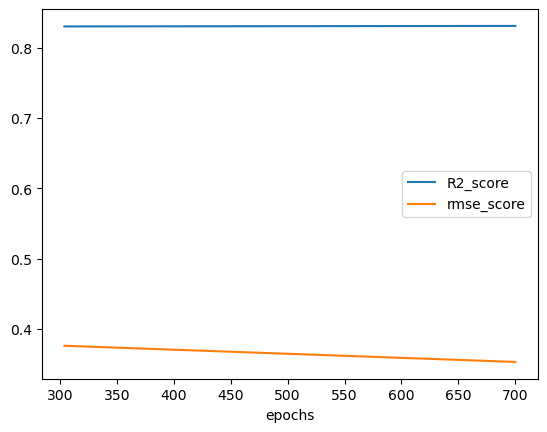

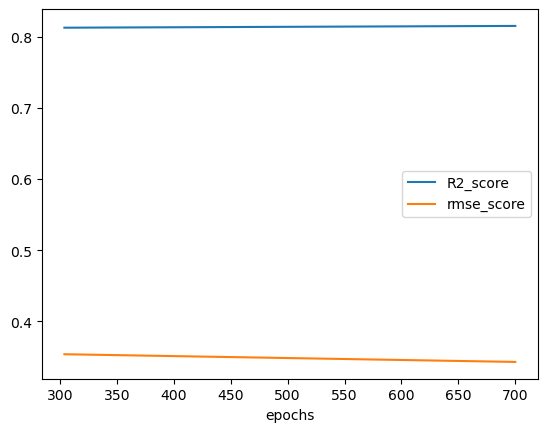

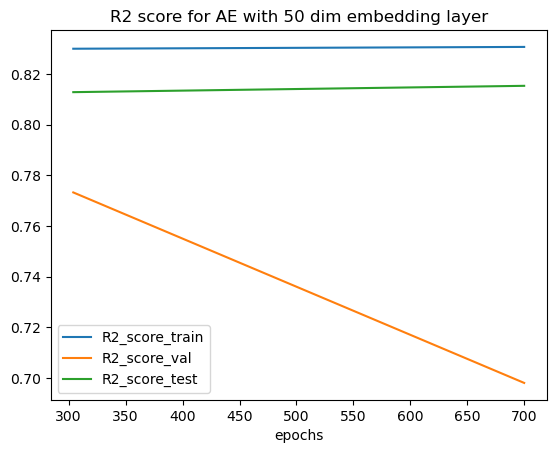

In [51]:
df_metrics['train'].plot(x = 'epochs', y=['R2_score','rmse_score'], kind='line', subplots=False)
df_metrics['test'].plot(x = 'epochs', y=['R2_score','rmse_score'], kind='line', subplots=False)
df_merge_metrics.plot(x = 'epochs', y=['R2_score_train','R2_score_val','R2_score_test',], kind='line', subplots=False, title = 'R2 score for AE with 50 dim embedding layer')
# I computed the R2 against the training and test data on the model that uses the SNN regularization, they are very similar (for example training = 0.3580, test= 0.3636) - this is for the latent layer size of 100. The
# Now I am running models without any regularization to with different latent layer sizes to see how the latent layer size affects the R2

### Autoencoder with SNNL regularization , embedding 100 dim


In [ ]:
df_tmp = pd.merge(df_metrics['train'][cols0],df_metrics['test'][cols0], how='inner', left_on = 'epochs', right_on = 'epochs', suffixes=('_train', None), indicator = False)
df_merge_metrics = pd.merge(df_tmp, df_metrics['val'][cols0], how='inner', left_on = 'epochs', right_on = 'epochs', copy = True, suffixes=('_test', '_val'), indicator = False)
df_merge_metrics[['epochs', 'R2_score_train','R2_score_val','R2_score_test','rmse_score_train','rmse_score_val','rmse_score_test']]

In [ ]:
df_merge_metrics.plot(x = 'epochs', y=['R2_score_train','R2_score_val','R2_score_test',], kind='line', subplots=False, title = 'R2 score for AE with 100 dim embedding layer')

### Baseline autoencoder , embedding 150 dim


In [ ]:
df_tmp = pd.merge(df_metrics['train'][cols0],df_metrics['test'][cols0], how='inner', left_on = 'epochs', right_on = 'epochs', suffixes=('_train', None), indicator = False)
df_merge_metrics = pd.merge(df_tmp, df_metrics['val'][cols0], how='inner', left_on = 'epochs', right_on = 'epochs', copy = True, suffixes=('_test', '_val'), indicator = False)
df_merge_metrics[['epochs', 'R2_score_train','R2_score_val','R2_score_test','rmse_score_train','rmse_score_val','rmse_score_test']]
df_merge_metrics.plot(x = 'epochs', y=['R2_score_train','R2_score_val','R2_score_test',], kind='line', subplots=False, title = 'R2 score for AE with 150 dim embedding layer')

In [ ]:
distance_matrices(grp_level_dict, epochs = [50,100,200,300])

### Baseline autoencoder , embedding 50 dim

In [ ]:
df_tmp = pd.merge(df_metrics['train'][cols0],df_metrics['test'][cols0], how='inner', left_on = 'epochs', right_on = 'epochs', suffixes=('_train', None), indicator = False)
df_merge_metrics = pd.merge(df_tmp, df_metrics['val'][cols0], how='inner', left_on = 'epochs', right_on = 'epochs', copy = True, suffixes=('_test', '_val'), indicator = False)
df_merge_metrics[['epochs', 'R2_score_train','R2_score_val','R2_score_test','rmse_score_train','rmse_score_val','rmse_score_test']]
df_merge_metrics.plot(x = 'epochs', y=['R2_score_train','R2_score_val','R2_score_test',], kind='line', subplots=False, title = 'R2 score for AE with 50 dim embedding layer')

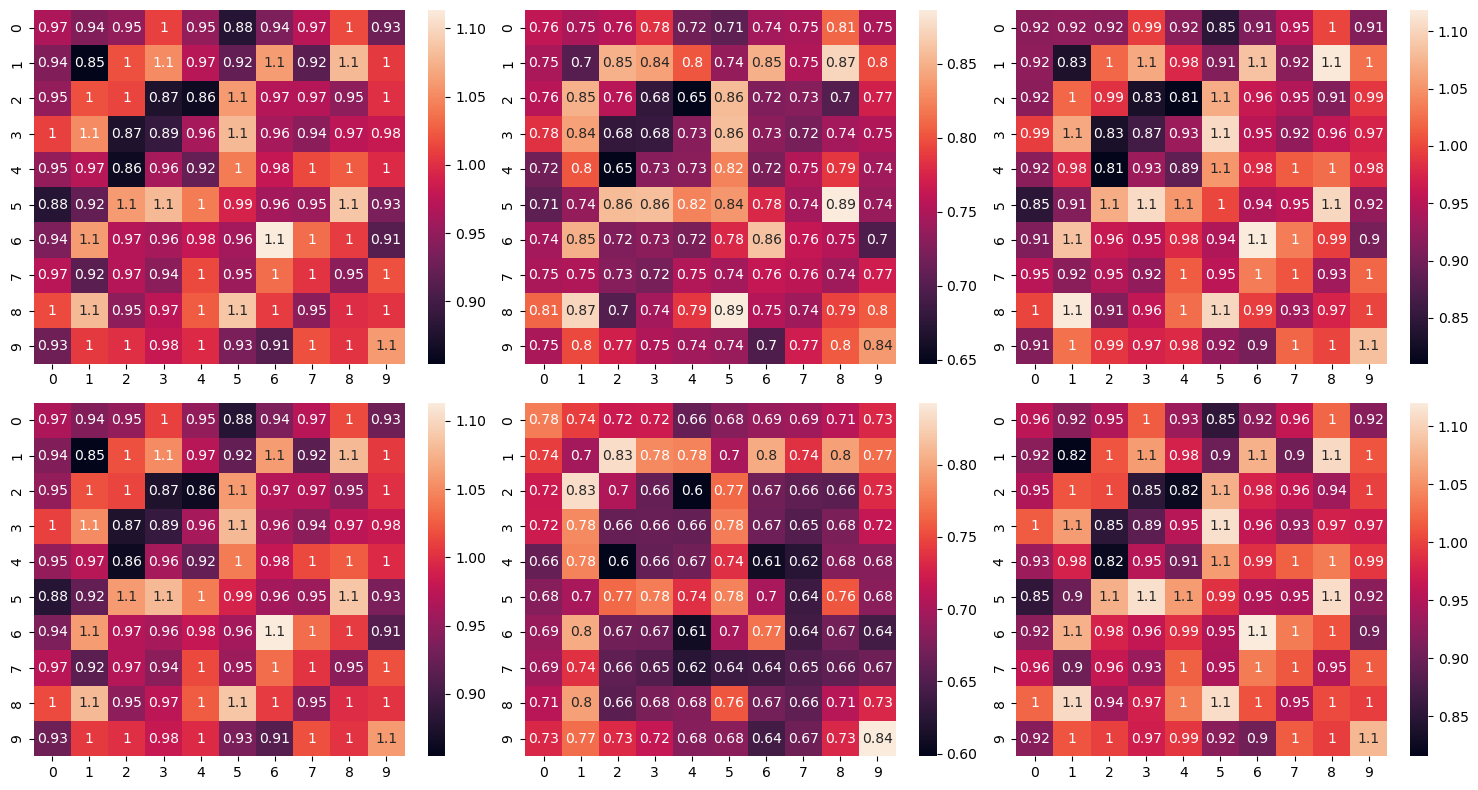

In [52]:
distance_matrices(grp_level_dict, epochs = [304,700])

## Write to csv and Excel files

In [ ]:
timestamp = datetime.now().strftime('%m%d_%H%M%S')
csv_filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{metric}_metrics_{timestamp}.csv"
csv_filename = os.path.join('./results', csv_filename)
csv_filename

excel_filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{metric}_metrics_{timestamp}.xlsx"
excel_filename = os.path.join('./results', excel_filename)
excel_filename

In [ ]:
excel_sheet = f"{'bl' if ex_runmode == 'baseline' else ex_runmode}_{timestamp}"
excel_sheet

In [ ]:
df_metrics.to_csv(csv_filename, index = False)
df_metrics.to_excel(excel_filename, sheet_name=excel_sheet, index_label='id')

In [ ]:
# mdl_outputs.embeddings[9].sum()
# mdl_outputs.y_pred.sum()
# mdl_outputs.compounds[:17]
df_metrics

## Read metrics CSV file

In [ ]:
input_file  = './results/AE_snnl_20240516_snglOpt-100Ltnt_euclidean_metrics_0603_130545.csv'
input_metrics = pd.read_csv(input_file)
input_metrics

In [ ]:
pattern1 = re.compile(r"(inp|emb|out)_(all|same|diff)_(avg)")
pattern2 = re.compile(r"(CL)_(inp|emb|out)_(all|same|diff)_(avg)")
cols1 = ['epochs', 'R2_score', 'rmse_score'] + [ col for col in metric_cols if pattern1.match(col) ]
cols2 = ['epochs', 'R2_score', 'rmse_score'] +[ col for col in metric_cols if pattern2.match(col) ]

In [ ]:
input_metrics[cols1]

# Metrics

## Distance Metrics

In [ ]:
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=250, nanstr='nan')

In [ ]:
# 1189.5788218820562 + 16009.773130260974 
# 2175.389955100794 / 50

In [ ]:
dmtrc = compute_distance_metrics(sample_activations, epochs, metric = 'euclid')

In [ ]:
# dmtrc.keys()

In [ ]:
dmtrc = compute_distance_metrics(sample_activations, epochs, metric = 'euclid')

In [ ]:
dmtrcs = compute_distance_metrics(sample_activations, epochs)

In [ ]:
display_distance_metrics(dmtrc, epochs)

In [ ]:
# print(f'INPUT features - Euclidean distances - {epochs} epochs')
# print('-'*20)
# dmtrc = distance_metric_1(inp_euc_distance)

# print(f'EMBEDDED features - Euclidean distances - {epochs} epochs')
# print('-'*20)
# dmtrc = distance_metric_1(emb_euc_distance)

# print(f'RECONSTURCTED features -  Euclidean distances - {epochs} epochs')
# print('-'*20)
# dmtrc = distance_metric_1(out_euc_distance)

### Cosine Distance 

In [ ]:
print(f'Input features - Cosine - {epochs} epochs')
print('-'*20)
grp_level_input = distance_metric_1(inp_cos_distance)
 
print(f'Output features - Cosine - {epochs} epochs')
print('-'*20)
grp_level_output = distance_metric_1(out_cos_distance)

In [ ]:
# inp_cos_distance[:5,:15]
# out_cos_distance[:5,:15]
# emb_cos_distance[:5,:15]

## Classification Metrics 

In [ ]:
cls_metrics = compute_classification_metrics(mdl_output)
cls_metrics.epochs = epochs
display_classification_metrics(cls_metrics)
plot_classification_metrics(cls_metrics)

#### 

In [ ]:
# test_accuracy = binary_accuracy(y_true=labels, y_prob=logits)
# test_f1 = binary_f1_score(y_true=labels, y_prob=logits)
# print(f"accuracy: {test_accuracy}%      F1 Score: {test_f1:.4f}")
# cm = confusion_matrix(y_true = labels, y_pred = (logits >= 0.5))
# disp = ConfusionMatrixDisplay(cm)
# disp.plot()


In [ ]:
# filename = f"DNN-{args.model.lower()}-{args.seed}.json"
# export_results(model=model, filename=filename)

In [ ]:
# for i in range(len(logits)):
#     if labels[i] == 1:
#         print(f" y_pred: {logits[i]:.5e}   {logits[i]>=0.500}  \t  y_true: {labels[i]}")

## Regression Metrics 

In [ ]:
mdl_outputs.epochs = epochs
reg_metrics = compute_regression_metrics(mdl_outputs)
# reg_metrics
print()
display_regr_metrics(reg_metrics)
df_metrics

In [ ]:
try:
    df_metrics = pd.concat((df_metrics, pd.DataFrame(vars(reg_metrics), index = [epochs] )) , verify_integrity=True)
    df_metrics.sort_index(inplace = True)
except ValueError:
    print(f" {epochs} already exists - not added")

In [ ]:
df_metrics

## Results

  #### Results `20240505_autoencoder`

In [ ]:
 metrics as epoch 25     metrics as epoch 50     metrics as epoch 100   metrics as epoch 125   metrics as epoch 150  
---------------------- -----------------------  ---------------------- ---------------------- ---------------------- 
RMSE Score :  0.543655  RMSE Score :  0.539906   RMSE Score : 0.536459  RMSE Score : 0.624126  RMSE Score : 0.624126 
 MSE Score :  0.317944   MSE Score :  0.314051    MSE Score : 0.310318   MSE Score : 0.408070   MSE Score : 0.408070 
 MAE Score :  0.378762   MAE Score :  0.373654    MAE Score : 0.371468   MAE Score : 0.434099   MAE Score : 0.434099 
  R2 Score :  0.611225    R2 Score :  0.615898     R2 Score : 0.632036    R2 Score : 0.518840    R2 Score : 0.518840 

  #### Results ` baseline 20240505_dropout04`

In [ ]:
 metrics at epoch  25   metrics at epoch  50   metrics at epoch  75   metrics at epoch 100   metrics at epoch 125   metrics at epoch 150   metrics at epoch 175   metrics at epoch 200   metrics at epoch 225   metrics at epoch 250   metrics at epoch 300   
---------------------- ---------------------- ---------------------- ---------------------- ---------------------- ---------------------- ---------------------- ---------------------- ---------------------- ---------------------- ----------------------  
RMSE Score :  0.539952 RMSE Score :  0.522212 RMSE Score :  0.516986 RMSE Score :  0.510535 RMSE Score :  0.512396 RMSE Score :  0.507615 RMSE Score :  0.501631 RMSE Score :  0.504048 RMSE Score :  0.505369 RMSE Score :  0.504147 RMSE Score :  0.503990  
 MSE Score :  0.313584  MSE Score :  0.295068  MSE Score :  0.289945  MSE Score :  0.283578  MSE Score :  0.285415  MSE Score :  0.280749  MSE Score :  0.275116  MSE Score :  0.277431  MSE Score :  0.278716  MSE Score :  0.277734  MSE Score :  0.277629  
 MAE Score :  0.372594  MAE Score :  0.361990  MAE Score :  0.357078  MAE Score :  0.353107  MAE Score :  0.353546  MAE Score :  0.350261  MAE Score :  0.345679  MAE Score :  0.346366  MAE Score :  0.347385  MAE Score :  0.346365  MAE Score :  0.345845  
  R2 Score :  0.610749   R2 Score :  0.630615   R2 Score :  0.648668   R2 Score :  0.661354   R2 Score :  0.658380   R2 Score :  0.622958   R2 Score :  0.670584   R2 Score :  0.674873   R2 Score :  0.670612   R2 Score :  0.670147   R2 Score :  0.670171   

  #### Results `snnl 20240507_secondTry`

In [ ]:
  metrics as epoch  25   metrics as epoch  50    metrics as epoch  75   metrics as epoch 100    metrics as epoch 125    metrics at epoch 150   metrics at epoch 175   metrics at epoch 200         
----------------------  ----------------------  ---------------------- ----------------------  ----------------------  ---------------------- ---------------------- ----------------------       
RMSE Score : 0.550294   RMSE Score :  0.536259  RMSE Score :  0.516979 RMSE Score :  0.513265  RMSE Score :  0.511261  RMSE Score :  0.506228 RMSE Score :  0.508196 RMSE Score :  0.508642       
 MSE Score : 0.324991    MSE Score :  0.310259   MSE Score :  0.290345  MSE Score :  0.286497   MSE Score :  0.284502   MSE Score :  0.279736  MSE Score :  0.281590  MSE Score :  0.282127       
 MAE Score : 0.382500    MAE Score :  0.372185   MAE Score :  0.358323  MAE Score :  0.353431   MAE Score :  0.351594   MAE Score :  0.347926  MAE Score :  0.348469  MAE Score :  0.348470       
  R2 Score : 0.588431     R2 Score :  0.625873    R2 Score :  0.652229   R2 Score :  0.657811    R2 Score :  0.656971    R2 Score :  0.667756   R2 Score :  0.665126   R2 Score :  0.661970        

### metrics per epoc

#### 25 epochs

In [ ]:
display_regr_metrics(reg_metrics)

#### 50 epochs

In [ ]:
display_regr_metrics(reg_metrics)

#### 75 epochs

In [ ]:
display_regr_metrics(reg_metrics)

#### 100 epochs

In [ ]:
display_regr_metrics(reg_metrics)

#### 125 epochs

In [ ]:
display_regr_metrics(reg_metrics)

#### 150 epochs

In [ ]:
display_regr_metrics(reg_metrics)

#### 175 epochs

In [ ]:
display_regr_metrics(epochs, rm)

#### 200 epochs

In [ ]:
display_regr_metrics(reg_metrics)

## Apply TSNe

In [ ]:
tsne = TSNE(2)
projection = dict()
num_layers = len(mdl_outputs.embeddings)
for k in range(num_layers):
    projection[k] = tsne.fit_transform(mdl_outputs.embeddings[k])
    print(f" layer {k+1} of {num_layers}: projection shape: {projection[k].shape}")
    

In [ ]:
# projection_subset = {x: projection[x] for x in range(6)}

# Plot TSNE embeddings

### 100 Epochs  

In [ ]:
# plot_TSNE(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', end = 21, epoch = mdl_outputs.epochs)
plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', items = list(range(21)), layers = [0,1,2,3,4], epoch = mdl_outputs.epochs)
plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', items = list(range(21)), layers = [5,6,7,8,9], epoch = mdl_outputs.epochs)
print('\n')
plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', layers = [0,8,9],  items = list(range(9)), epoch = mdl_outputs.epochs, limits=(-50,50))
plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', layers = [0,8,9],  items = [3,4,5], epoch = mdl_outputs.epochs, limits=(-50,50))
print('\n')
plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='tpsa', layers = [0,1,2,3,4],epoch = mdl_outputs.epochs)
plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='tpsa', layers = [5,6,7,8,9],epoch = mdl_outputs.epochs)

### 200 Epochs  

In [ ]:
# plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', items = list(range(21)), layers = [0,1,2,3,4], epoch = mdl_outputs.epochs)
# plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', items = list(range(21)), layers = [5,6,7,8,9], epoch = mdl_outputs.epochs)
# print('\n')
# plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', layers = [0,8,9],  items = list(range(9)), epoch = mdl_outputs.epochs, limits=(-50,50))
# plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', layers = [0,8,9],  items = [3,4,5], epoch = mdl_outputs.epochs, limits=(-50,50))

print('\n')
fig1 = plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='tpsa', layers = [0,1,2,3,4],epoch = mdl_outputs.epochs)
fig2 = plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='tpsa', layers = [5,6,7,8,9],epoch = mdl_outputs.epochs)

In [ ]:
filename1 = f"./images/{model.name}_{ex_mode}_{timestamp}_{title}_{epochs:03d}_allcmpds_tpsa_1.jpg"
filename2 = f"./images/{model.name}_{ex_mode}_{timestamp}_{title}_{epochs:03d}_allcmpds_tpsa_2.jpg"
fig1.savefig(filename1)
fig2.savefig(filename2)

In [ ]:
Image('test.png')

### 225 Epochs  

In [ ]:
# plot_TSNE(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', end = 21, epoch = mdl_outputs.epochs)
plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', items = list(range(21)), layers = [0,1,2,3,4], epoch = mdl_outputs.epochs)
plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', items = list(range(21)), layers = [5,6,7,8,9], epoch = mdl_outputs.epochs)

In [ ]:
plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', layers = [0,4,8,9],  items = list(range(9)), epoch = mdl_outputs.epochs, limits=(-50,50))
plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', layers = [0,4,8,9],  items = [3,4,5], epoch = mdl_outputs.epochs, limits=(-50,50))

In [ ]:
plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='tpsa', layers = [0,1,2,3,4],epoch = mdl_outputs.epochs)
plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='tpsa', layers = [5,6,7,8,9],epoch = mdl_outputs.epochs)

### 300 Epochs  

In [ ]:
plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='tpsa', layers = [1,3,4,6,8,9],epoch = mdl_outputs.epochs)

In [ ]:
plot_TSNE_2(projection, mdl_outputs.labels, mdl_outputs.comp_labels, key='compound', layers = [0,4,9],  items = list(range(9)), epoch = mdl_outputs.epochs)

# Older plots

### Based on Compound 

In [ ]:
for layer in [0,1,2,3,4]:
    end = 15
    df = pd.DataFrame(dict(
        x=projection[layer][:end,0],
        y=projection[layer][:end,1],
        label=labels[0:end],
        comp_label = comp_labels[0:end]
    ))
    # _=plt.figure()
    lp=sb.lmplot( data=df, x ="x", y = "y", hue='comp_label', fit_reg=False, palette="hls") #, size=6)
    _=lp.fig.suptitle(f'layer {layer}')

plt.show()

### Based on TPSA Indicator 

In [ ]:
end = 1200
for layer in [0,1,2,3,4]:
    df = pd.DataFrame(dict(
        x=projection[layer][:end,0],
        y=projection[layer][:end,1],
        label=labels[0:end]
    ))
    lp= sb.lmplot( data=df, x ="x", y = "y", hue='label', fit_reg=False, palette="hls") #, size=6)
    _=lp.fig.suptitle(f'layer {layer}')
plt.show()

### 3D ? 

In [ ]:
from matplotlib import cm
x=projection[4][:,0]
y=projection[4][:,1]
# z=projection[4][:,2]
label=np.expand_dims(labels,-1)
z = np.expand_dims(z,-1)
z.shape

ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
# Plot the 3D surface
# ax.plot_surface(x, y, z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8, alpha=0.3)
# ax.plot_trisurf(x, y, z, linewidth=0 , )
# surf = ax.plot_surface(x, y, label, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(x, y, label)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()
ax.view_init(elev=45.)

plt.show()

# PCA and TSNE

## define PCA model

In [ ]:
loader_iter = iter(train_loader)

In [ ]:
(batch_features, batch_labels, batch_plates, batch_compounds, batch_hash) = next(loader_iter)

In [ ]:
type(batch_features), batch_features.shape, batch_labels.numpy().shape

In [ ]:
pca = PCA(n_components=200, copy=False, whiten=False, 
          svd_solver='auto', tol=0.0, iterated_power='auto', 
          n_oversamples=10, power_iteration_normalizer='auto', random_state=None)

In [ ]:
pca.fit(batch_features)
X = pca.transform(batch_features)

## define TSNE 

In [ ]:
tsne = TSNE()
projection = tsne.fit_transform(X)
projection.shape

In [ ]:
rows = 1000
df = pd.DataFrame(dict(
    x=projection[:rows,0],
    y=projection[:rows,1],
    label=batch_labels.numpy()[:rows]
    # moa=pd.concat([treated_wells["MOA"], treatments["MOA"]]),
    # batch=pd.concat([treated_wells["Plate"].apply(lambda x: x.split("_")[0]), treatments["Batch"]]),
    # compound=pd.concat([treated_wells["Compound"], treatments["Compound"]]),
    # correct=pd.concat([treated_wells["nsc"],treatments["nsc"]]),
    # level=pd.concat([treated_wells["level"],treatments["level"]])
))

df.info()
df.head()

In [ ]:
plt.figure()
# sb.lmplot('x', 'y', data=df, hue='label', fit_reg=False, palette="hls", size=6)
sb.lmplot( data=df, x ="x", y = "y", hue='label', fit_reg=False, palette="hls") #, size=6)


## Apply TSNE on embeddings

In [ ]:
tsne = TSNE(2)
projection = dict()
for k,v in embeddings.items():
    projection[k] = tsne.fit_transform(v)
    projection[k].shape

#### Layer 0 

In [ ]:
df = pd.DataFrame(dict(
    x=projection[0][:,0],
    y=projection[0][:,1],
    label=labels
))
plt.figure()
sb.lmplot( data=df, x ="x", y = "y", hue='label', fit_reg=False, palette="hls") #, size=6)

#### Layer 1 

In [ ]:
df = pd.DataFrame(dict(
    x=projection[1][:,0],
    y=projection[1][:,1],
    label=labels
))
plt.figure()
sb.lmplot( data=df, x ="x", y = "y",hue='label', fit_reg=False, palette="hls") #, size=6)

#### Layer 2 

In [ ]:
df = pd.DataFrame(dict(
    x=projection[2][:,0],
    y=projection[2][:,1],
    label=labels
))
plt.figure()
sb.lmplot( data=df, x ="x", y = "y",hue='label', fit_reg=False, palette="hls") #, size=6)

#### Layer 3 

In [ ]:
df = pd.DataFrame(dict(
    x=projection[3][:,0],
    y=projection[3][:,1],
    label=labels
))
plt.figure()
sb.lmplot( data=df, x ="x", y = "y",hue='label', fit_reg=False, palette="hls") #, size=6)

#### Layer 4 

In [ ]:
df = pd.DataFrame(dict(
    x=projection[4][:,0],
    y=projection[4][:,1],
    label=labels
))
plt.figure()
sb.lmplot( data=df, x ="x", y = "y",hue='label', fit_reg=False, palette="hls") #, size=6)

In [ ]:
np.bincount(labels.astype(np.int64))

In [ ]:
from matplotlib import cm
x=projection[4][:,0]
y=projection[4][:,1]
# z=projection[4][:,2]
label=np.expand_dims(labels,-1)
z = np.expand_dims(z,-1)
z.shape

ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
# Plot the 3D surface
# ax.plot_surface(x, y, z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8, alpha=0.3)
# ax.plot_trisurf(x, y, z, linewidth=0 , )
# surf = ax.plot_surface(x, y, label, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(x, y, label)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()
ax.view_init(elev=45.)

plt.show()